In [ ]:
# I like to start by checking if the GPU was initiated succesfully,
# and by seeing the tensroflow and python versions being used
# by the notebook.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------

%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
import os, sys, tarfile, time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)


Runtime: 1 min 11 sec


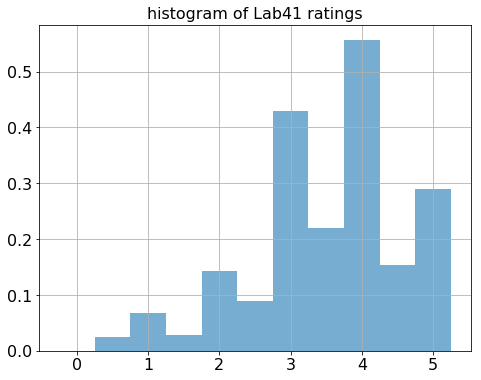

In [3]:
# Read Lab41 dataset into:
#                          train_Y, cv_Y, test_Y
#                          train_Y_indices, cv_Y_indices, test_Y_indices

start = time.time()
#...................................................
train_Y_indices, train_Y, cv_Y_indices, cv_Y, test_Y_indices, test_Y, n_users, n_movies = read_and_split_data()

ax = plt.subplot(121)
ax.hist(np.concatenate((train_Y,cv_Y,test_Y)), bins=np.arange(-0.25,5.75,0.5),alpha=.6, normed=True);
ax.set_title('histogram of Lab41 ratings');

print_runtime(start)

NUM_EPOCHS: 1
LAMBDA: 0
k: 10
lr: 0.01
n_batches: 781
BATCH_SIZE: 16384

New epoch: 1 ******************************
Runtime: 1 min 29 secestimate: 1.0071, t= 68.31 sec


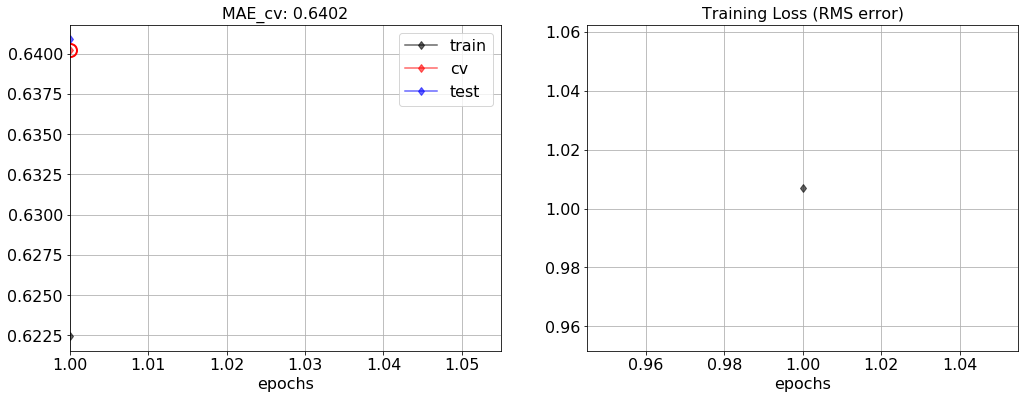

In [6]:
# hyperparameters
# BATCH_SIZE = 1024*16
BATCH_SIZE_arr = [1024*16, 1024*8, 1024*4, 1024*2, 1024, 512, 256, 128]
# LAMBDA_ARR = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.00125]
LAMBDA = 0
k = 10 # an important hyperparameter.
lr = 0.01
NUM_EPOCHS = 1

for BATCH_SIZE in BATCH_SIZE_arr:
    #.............................................. 
    train, loss, reg, Y_indices, Y, U, V, Y_pred, UV_xft, UU_xft, VV_xft = \
                            construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
    #.............................................. 

    start = time.time()
    mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, mean_preds, n_batches, preds, \
                   _U, _V, _UV_xft, _UU_xft, _VV_xft = \
                         train_the_model(Y_indices, Y, train_Y_indices, train_Y, BATCH_SIZE, 
                   NUM_EPOCHS, LAMBDA, k, lr, 
                   train, loss, reg, U, V, Y_pred,
                   cv_Y, cv_Y_indices, test_Y, test_Y_indices,
                   UV_xft, UU_xft, VV_xft)
    #.............................................. 
    # plotting....
    ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr)

#.............................................. 
print_runtime(start)

In [ ]:
print('n_batches: {}\nk: {}\nlr: {}\nNUM_EPOCHS: {}'.format(n_batches, k, lr, NUM_EPOCHS))
i_min = np.argmin(mae_cv_arr)
print('min(mae_train): %6.4f, **mae_cv: %6.4f**, mae_test: %6.4f,  mean(preds): %6.4f' % 
      (min(mae_train_arr), mae_cv_arr[i_min], mae_test_arr[i_min], np.mean(preds)))
ax1, ax2 = plotter( mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr)
# print('(_reg/_loss) fraction: %6.4f' % (_reg/_loss_S))


In [ ]:
ax = plt.subplot(111)
ax.plot(U[:,0],'b-',alpha=.75);
ax.set_title('LAMBDA: %6.5f' % (LAMBDA));


In [ ]:
# regularization towards 3.5, xft terms ommitted from reg.
LAMDA_arr = [0.0001, 0.0005, 0.00075, .001, .00125, 0.002] 
mae_cv_arr_L = [.6157, .6139, 0.6132, .6132, 0.6153, 0.6150]
ax = plt.subplot(111)
ax.plot(LAMDA_arr, mae_cv_arr_L, 'b-d', alpha=.75);
ax.set_title('mae_cv vs LAMDA');
ax.set_xlabel('LAMDA');